# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры для определения рыночной стоимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. (Например, расстояние до центра, аэропорта, ближайшего парка и водоёма). 

**Содержание**

1. [Обзор данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений и изменение типов данных](#null)
        * [Баг-репорт](#bug-report)
    * [Расчет дополнительных параметров](#features)
    
3. [Исследовательский анализ данных](#research)
4. [Взаимосвязи в данных](#correlation)
    * [Сравнение квартир в центре Санкт-Петербурга и в целом по городу](#spbvscenter)
5. [Выводы](#summary)

In [1]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Обзор данных<a id="start"></a>

In [2]:
#прочитаем файл и посмотрим на первые строчки датасета
data = pd.read_csv('real_estate_data.csv', sep = '\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
#посмотрим на размер файла и названия столбцов, 
#сколько пропусков в датасете и правильные ли типы данных в столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Заметно, что в датасете довольно много пропусков, а в некоторых столбцах стоит поменять тип данных: например, столбец is_apartment лучше перевести в bool, а столбцы с датами - в datetime.

In [4]:
#посчитаем количество пропусков во всех столбцах
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Есть пропуски в столбцах: 
- ceiling_height — высота потолков (м)
- floors_total — всего этажей в доме
- living_area — жилая площадь в квадратных метрах(м²)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- balcony — число балконов
- is_apartment — апартаменты
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)

А также в автоматически сгенерированных столбцах (на основе картографических данных): название населенного пункта, расстояние до ближайшего аэропорта, парка, водоема, центра города.

Чем могут объясняться пропуски в датасете?

- Пропуски в столбцах с *высотой потолков, жилой площадью и площадью кухни* могут объясняться тем, что продавцы не знают точных значений или считают, что наличие этих цифр в объявлении не критично. 

А может быть, продавцы не хотят акцентировать внимание потенциальных покупателей на том, что потолки не очень высокие, кухня довольно маленькая, а планировка не самая удачная.

- Пропуски в столбцах с *количеством балконов и апартаментами*, вероятно, объясняются тем, что люди не заполняют эти необязательные поля при добавлении объявлений. Скорее всего, пропуски в этих столбцах по умолчанию означают, что в квартире нет балконов и жилье не является апартаментами. 

В таком случае, пропуски можно заполнить нулями.

- Пропуски в *автоматически сгенерированных столбцах*, скорее всего, объясняются техническими причинами. Возможно, расстояние до ближайшего аэропорта, парка, водоема или центра города превышает установленное значение. Или произошел какой-то сбой в системе при заполнении этих данных. 

Стоит составить баг-репорт для технических специалистов, чтобы они смогли узнать об этой проблеме, разобраться в ней и устранить её.

In [5]:
#проверим датасет на наличие дубликатов
data.duplicated().sum()

0

В датасете довольно много пропусков и столбцов с неправильным типом данных. Нужна предобработка данных, чтобы привести датасет к виду, удобному для дальнейшей работы.

# Предобработка данных<a id="preprocessing"></a>

## Обработка пропущенных значений и изменение типов данных<a id='null'></a>

Больше всего пропусков - в столбце **is_apartment**:

In [6]:
data.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

В датасете 23699 строк, но только по 2775 из них (менее 12%) есть информация о том, является объект недвижимости квартирой или апартаментом. Это важная информация, но данных слишком мало, чтобы делать какие-то выводы, опираясь на этот параметр. Поэтому удалим этот столбец:

In [7]:
data.drop('is_apartment', 1, inplace = True)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Еще много пропусков в стобце **balcony**. Посмотрим, какие данные представлены в заполненных ячейках этого столбца:

In [8]:
data.balcony.value_counts().sort_index()

0.0    3758
1.0    4195
2.0    3659
3.0      81
4.0     183
5.0     304
Name: balcony, dtype: int64

Скорее всего, если количество балконов не указано - их нет. Заменим пропуски нулями и заодно приведем значения к целочисленному виду:

In [9]:
data.balcony = data.balcony.fillna(0).astype(int)
data.balcony.value_counts().sort_index()

0    15277
1     4195
2     3659
3       81
4      183
5      304
Name: balcony, dtype: int64

Из данных, заполняемых пользователями, остались пропуски в столбцах:
- ceiling_height — высота потолков (м)
- floors_total — всего этажей в доме
- living_area — жилая площадь в квадратных метрах(м²)
- kitchen_area — площадь кухни в квадратных метрах (м²)

Все это важные параметры жилья, влияющие на его стоимость. Удалить их, заменить нулями или средними значениями будет неправильно.

Впрочем, в столбце с количеством этажей в здании **floors_total** пропусков совсем мало (86). Удалим их и приведем значения столбца к целочисленному виду. А пропуски в остальных столбцах пока оставим без изменений.

In [10]:
data.dropna(subset = ['floors_total'], inplace = True)
data.floors_total = data.floors_total.astype(int)
data.floors_total.value_counts().head(7)

5     5788
9     3761
16    1376
12    1362
4     1200
10    1174
25    1075
Name: floors_total, dtype: int64

Еще один столбец с очень маленьким количеством пропусков (48) - **locality_name**. Заполнить этот столбец на основе других данных датасета не получится: нет других столбцов, из которых можно было бы получить название населенного пункта. Поэтому лучше удалить строки с отсутствующими значениями:

In [11]:
data.dropna(subset = ['locality_name'], inplace = True)
data.locality_name.isna().sum()

0

Осталось довольно много пропусков в автоматически сгенерированных столбцах: 
- airports_nearest         5532
- cityCenters_nearest      5509
- parks_around3000         5508
- parks_nearest           15568
- ponds_around3000         5508
- ponds_nearest           14552
- days_exposition          3172

Количество пропусков в столбцах **airports_nearest, cityCenters_nearest, parks_around3000 и ponds_around3000** примерно совпадает. Возможно, это одни и те же объекты:

In [12]:
data[(data['airports_nearest'].isna()) & (data['cityCenters_nearest'].isna()) & (data['parks_around3000'].isna()) & (data['ponds_around3000'].isna()) & (data['parks_nearest'].isna()) & (data['ponds_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12,14.40,5,False,...,9.10,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27,15.43,26,False,...,8.81,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5,30.00,5,False,...,9.00,0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25,30.00,15,False,...,11.00,2,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9,NaN,2,False,...,NaN,0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5,45.50,3,False,...,5.50,0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5,17.50,4,False,...,6.00,0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5,38.00,4,False,...,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3,29.70,1,False,...,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так и есть: 5500 строк с отсутствующими значениями в 6 автоматически сгенерированных столбцах.

In [13]:
data[(data['parks_nearest'].isna()) & (data['ponds_nearest'].isna()) & (data['ponds_around3000'] == 0) & (data['parks_around3000'] == 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26,10.6,6,False,...,14.4,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24,NaN,22,False,...,18.9,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9,43.6,7,False,...,6.5,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0
11,9,3300000.0,44.0,2018-08-27T00:00:00,2,NaN,5,31.0,4,False,...,6.0,1,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23680,14,5000000.0,59.0,2019-04-04T00:00:00,3,2.50,5,52.0,1,False,...,7.0,0,Санкт-Петербург,26835.0,11878.0,0.0,NaN,0.0,NaN,NaN
23684,20,21400000.0,145.0,2018-11-02T00:00:00,4,3.00,26,71.4,17,False,...,15.6,0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.0,2019-01-24T00:00:00,1,2.50,5,17.3,5,False,...,5.6,1,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23687,6,3200000.0,39.0,2017-12-16T00:00:00,1,NaN,9,20.0,6,False,...,11.0,2,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0


И еще 5790 строк, где данные в столбцах parks_nearest и ponds_nearest отсутствуют, а в столбцах parks_around3000 и ponds_around3000 равны 0.

В строках с пропущенными значениями в автоматически сгенерированных столбцах содержатся данные за разные годы и по разным населенным пунктам. Скорее всего, пропуски в данных обусловлены какой-то технической ошибкой. Передадим коллегам баг-репорт с этими датасетами.

### Баг-репорт<a id='bug-report'></a>

In [14]:
#Больше 23% строк в датасете содержат пропуски в автоматически сгенерированных столбцах. 
#Это слишком много. Нужно понять, почему пропусков так много, и попробовать уменьшить их количество.

#По этим объектам отсутствуют данные в 6 автоматически сгенерированных столбцах одновременно:
bug_6missing = data[(data['airports_nearest'].isna()) & (data['cityCenters_nearest'].isna()) 
                    & (data['parks_around3000'].isna()) & (data['ponds_around3000'].isna()) 
                    & (data['parks_nearest'].isna()) & (data['ponds_nearest'].isna())]

#По этим объектам отсутствуют данные в столбцах parks_nearest и ponds_nearest, 
#а в столбцах parks_around3000 и ponds_around3000 нули.
bug_2missing_2zero = data[(data['parks_nearest'].isna()) & (data['ponds_nearest'].isna()) 
                    & (data['ponds_around3000'] == 0) & (data['parks_around3000'] == 0)]

Мы не можем удалить 23% данных, но и заменить отсутствующие значения нулями или средними значениями будет неправильно: это может исказить наши выводы при дальнейшем анализе. Пока оставим значения в этих столбцах как есть.

Почему отсутствуют значения в столбце **days_exposition**? Есть гипотеза, что пропуски в этом столбце соответствуют объектам, которые еще не сняты с публикации (на момент выгрузки данных). Проверим это.

In [15]:
#Приведем столбец с датой **first_day_exposition** к удобному для работы виду:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [16]:
data[data['days_exposition'].isna()].first_day_exposition.dt.year.value_counts()

2019    1788
2018     957
2017     271
2015      70
2016      67
2014      18
Name: first_day_exposition, dtype: int64

Похоже на правду: большая часть объявлений с отсутствующим количеством дней публикации была опубликована в текущем или прошлом году (относительно даты выгрузки в мае 2019 года). Эти объявления могли быть актуальны на момент выгрузки данных.

С другой стороны, есть больше 400 объектов, которые на момент выгрузки находились на публикации около 1.5 лет и более. Вероятно, это не самая востребованная недвижимость. Но нам сложно будет сделать выводы об этом, если мы не увидим, как долго объект недвижимости находится в продаже.

Можно посчитать, сколько дней объявление уже находилось на публикации на момент выгрузки, и заменить пропуски этими значениями. Но не исказит ли это данные? Обычно объявление снимают с публикации тогда, когда квартира продана. При таком способе замены пропусков мы логически отнесем эти объекты к уже проданным на момент выгрузки (а это не так). Это может привести к неправильным выводам при последующем анализе.

Чтобы избежать такой проблемы, можно добавить дополнительный столбец not_sold, в котором отдельно пометим объекты, которые еще не были проданы (сняты с публикации) на момент выгрузки данных.

In [17]:
data['not_sold'] = data['days_exposition'].isna()

In [18]:
data.not_sold.value_counts()

False    20394
True      3171
Name: not_sold, dtype: int64

Мы пометили, что строки с отсутствующим количеством дней публикации - это объекты, которые еще не проданы на момент выгрузки данных.

Теперь можем заменить пропуски количеством дней публикации на момент выгрузки данных. Сначала узнаем дату выгрузки:

In [19]:
data['first_day_exposition'].value_counts().sort_index(ascending = False).head(10)

2019-05-03    20
2019-05-02    11
2019-05-01    30
2019-04-30    27
2019-04-29    37
2019-04-28    18
2019-04-27    14
2019-04-26    37
2019-04-25    28
2019-04-24    33
Name: first_day_exposition, dtype: int64

Можно предположить, что дата выгрузки - 05.03.2019, т.к. именно этой датой заканчиваются значения в столбце с датами публикации объявлений. Заменим пропуски разницей между этой датой (сохраним ее в переменную `max_date`) и датой публикации:

In [20]:
max_date = data['first_day_exposition'].max()

In [21]:
data.loc[data['days_exposition'].isna(), 'days_exposition'] = data.loc[data['days_exposition'].isna(), 'first_day_exposition'].map(lambda x: (max_date - x).days)

In [22]:
#приведем значения в этом столбце к целочисленному виду
data['days_exposition'] = data['days_exposition'].astype('int')

In [23]:
#проверим, что пропусков больше нет
data.days_exposition.isna().sum()

0

In [24]:
#посмотрим, какими значениями заменились пропуски
data[data['not_sold'] == True].days_exposition.value_counts().sort_values(ascending = False).head(10)

11    46
15    44
29    36
25    36
4     36
7     35
16    34
18    34
9     32
17    32
Name: days_exposition, dtype: int64

Замена прошла успешно: пропусков больше нет, а среди заполненных нами значений преобладают небольшие (до 30 дней). В соответствии с нашей гипотезой.

Итак, мы обработали пропущенные значения и изменили тип данных, где это было необходимо. 

А также составили баг-репорт, чтобы избавиться от ошибок при следующей выгрузке данных.

## Расчет дополнительных параметров <a id='features'></a>

Добавим в датасет дополнительные параметры, которые могут влиять на стоимость недвижимости:

- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры (первый, последний, другой);
- соотношение жилой и общей площади, а также отношение площади кухни к общей.

### Стоимость за квадратный метр

Высчитаем **цену за метр**. Но сначала проверим, нет ли в столбцах со стоимостью и площадью аномальных значений.

Переведем цены в миллионы для удобства дальнейшей работы:

In [25]:
data['last_price'] = data['last_price'].apply(lambda x: x / 1000000)

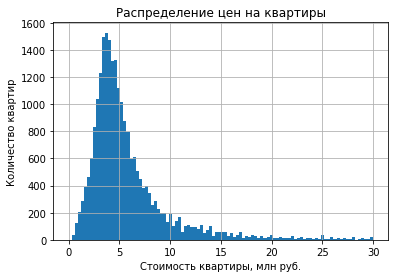

In [26]:
data.hist('last_price', range = (0, 30), bins = 100)
plt.title('Распределение цен на квартиры')
plt.xlabel('Стоимость квартиры, млн руб.')
plt.ylabel('Количество квартир');

Распределение цен на квартиры в датасете близко к нормальному, с длинным хвостом очень дорогих квартир. Посмотрим на самые дешевые и самые дорогие квартиры.

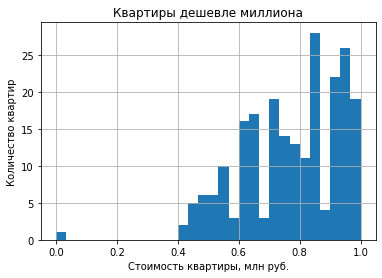

In [27]:
data[data['last_price'] < 1].hist('last_price', range = (0, 1), bins = 30)
plt.title('Квартиры дешевле миллиона')
plt.xlabel('Стоимость квартиры, млн руб.')
plt.ylabel('Количество квартир');

In [28]:
data[data['last_price'] < 0.1].last_price.value_counts()

0.01219    1
Name: last_price, dtype: int64

Квартира точно не может стоить 12 190 руб. Удалим эту строку:

In [29]:
data.drop(data[data['last_price'] == 0.01219].index, inplace = True)

In [30]:
data.last_price.min()

0.43

Теперь посмотрим, как обстоят дела с очень дорогими квартирами:

In [31]:
data[data['last_price'] > 70].last_price.count()

76

В датасете 76 квартир дороже 70 млн руб, вот самые дорогие:

In [32]:
data.last_price.value_counts().sort_index().tail(10)

190.8700    1
230.0000    1
240.0000    1
245.0000    1
289.2384    1
300.0000    1
330.0000    1
401.3000    1
420.0000    1
763.0000    1
Name: last_price, dtype: int64

Такие квартиры - штучный товар. Или это какая-то ошибка?

In [33]:
#какая средняя площадь очень дорогих квартир?
data[data['last_price'] > 70].total_area.median()

250.65

In [34]:
#где расположены самые дорогие квартиры?
data[data['last_price'] > 70].locality_name.value_counts()

Санкт-Петербург    76
Name: locality_name, dtype: int64

Все квартиры дороже 70 млн находятся в Санкт-Петербурге и имеют большую площадь. Похоже на правду.

Теперь проверим значения в столбце с площадью квартир:

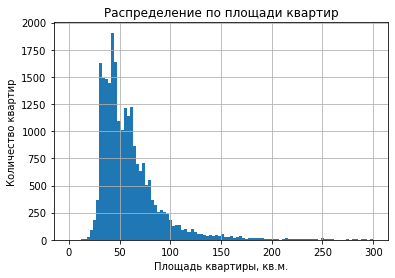

In [35]:
data.hist('total_area', range = (0, 300), bins = 100)
plt.title('Распределение по площади квартир')
plt.xlabel('Площадь квартиры, кв.м.')
plt.ylabel('Количество квартир');

Примерно такая же картина, как с ценой: распределение близко к нормальному, с длинным хвостом очень больших квартир. Посмотрим на самые большие квартиры, нет ли там аномальных значений?

In [36]:
data.total_area.describe()

count    23564.000000
mean        60.320758
std         35.656406
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Все выглядит правдоподобно, кроме минимального и максимального значения.

In [37]:
data[data.total_area < 15].sort_values('last_price', ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,not_sold
19807,0,3.800,13.0,2018-07-04,1,NaN,5,10.0,3,False,...,0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9,False
19904,4,2.400,12.0,2017-07-19,1,2.55,5,10.0,2,False,...,0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200,False
19546,3,1.850,13.0,2019-03-11,1,3.40,5,NaN,2,False,...,0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24,False
19558,2,1.686,13.2,2018-12-17,1,NaN,5,NaN,1,False,...,0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19,False
17961,3,1.400,13.0,2017-12-03,1,2.60,9,NaN,1,False,...,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410,False
19642,5,1.190,14.0,2018-07-29,1,NaN,5,11.0,1,False,...,0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4,False


Квартиры метражом от 12 до 15 м2 и стоимостью от 1.2 млн до 3.8 млн руб? Наверное, они очень хорошо расположены. По крайней мере, ничего, кроме соотношения "метраж-цена" не указывает на ошибку.

In [38]:
data[data.total_area > 450][['total_area', 'rooms', 'last_price']].sort_values('last_price')

,total_area,rooms,last_price
20273,460.8,6,20.000000
6221,470.3,4,34.000000
9826,494.1,1,43.185328
660,483.9,7,49.950000
4237,517.0,7,50.000000
5358,590.0,15,65.000000
8018,507.0,5,84.000000
22494,491.0,5,91.075000
12401,495.0,7,91.500000
6621,488.0,5,99.000000


Цены и количество комнат в целом соответствуют метражу, кроме разве что объекта с id 9826. Но, возможно, это какой-то огромный лофт.

Теперь можем высчитать **стоимость за метр** и добавить это значение в отдельный столбец:

In [39]:
data['metre_price'] = data['last_price'] / data['total_area'] * 1000000

In [40]:
data['metre_price'] = data['metre_price'].astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,not_sold,metre_price
0,20,13.000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,57,True,120370
1,7,3.350,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,False,82920
2,10,5.196,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,False,92785
3,0,64.900,159.0,2015-07-24,3,NaN,14,NaN,9,False,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,False,408176
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,False,100000


In [41]:
data.metre_price.median()

95000.0

### Тип этажа: первый, последний или другой

Добавим еще одну важную характеристику - **этаж**. Нас будет интересовать не конкретный этаж, а информация о том, расположена ли квартира на первом или последнем этажах (это влияет на цену), или на любом другом. Добавим столбец с этой информацией:

In [42]:
data[data.floor == 1].floor.count()

2909

In [43]:
data[data.floor == data.floors_total].floor.count()

3354

Всего в датасете 2909 квартир на первом этаже и 3354 - на последнем.

In [44]:
#напишем функцию для классификации этажей на "первый", "последний" и "другой"
#def floor_type(row):
#    if row['floor'] == 1:
#        return 'первый'
#    elif row['floor'] == row['floors_total']:
#       return 'последний'
#   else:
#       return 'другой'
#создадим столбец с типом этажа
#data['floor_type'] = data.apply(floor_type, axis = 1)

In [45]:
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[(data['floor'] != 1) & (data['floor'] == data['floors_total']), 'floor_type'] = 'последний'
data.loc[(data['floor'] != 1) & (data['floor'] != data['floors_total']), 'floor_type'] = 'другой'

In [46]:
data.floor_type.value_counts()

другой       17326
последний     3329
первый        2909
Name: floor_type, dtype: int64

In [47]:
data[(data.floor == 1) & (data.floor == data.floors_total)].floor_type.value_counts()

первый    25
Name: floor_type, dtype: int64

Квартиры, которые расположены на первом этаже одноэтажного дома, отнесли к категории "первый", а не "последний", что кажется логичным.

### Соотношение жилой и общей площади, отношение кухни к общей площади

Посчитаем еще две важные переменные, которые влияют на цену: 
- **соотношение жилой и общей площади**;
- **отношение площади кухни к общей площади**:

In [48]:
data['kitchen'] = data['kitchen_area'] / data['total_area']
data['living'] = data['living_area'] / data['total_area']
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,not_sold,metre_price,floor_type,kitchen,living
0,20,13.000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1.0,482.0,2.0,755.0,57,True,120370,другой,0.231481,0.472222
1,7,3.350,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,0.0,NaN,0.0,NaN,81,False,82920,первый,0.272277,0.460396
2,10,5.196,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,1.0,90.0,2.0,574.0,558,False,92785,другой,0.148214,0.612500
3,0,64.900,159.0,2015-07-24,3,NaN,14,NaN,9,False,...,2.0,84.0,3.0,234.0,424,False,408176,другой,NaN,NaN
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2.0,112.0,1.0,48.0,121,False,100000,другой,0.410000,0.320000


In [49]:
#проверим, что получилось
data[data.kitchen == data.kitchen.max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,not_sold,metre_price,floor_type,kitchen,living
11579,7,4.3,33.0,2016-05-13,1,NaN,16,26.0,14,False,...,0.0,NaN,0.0,NaN,180,False,130303,другой,0.787879,0.787879


Бывает, в однушке делают перепланировку, объединяя кухню с комнатой. Наверное, это тот самый случай.

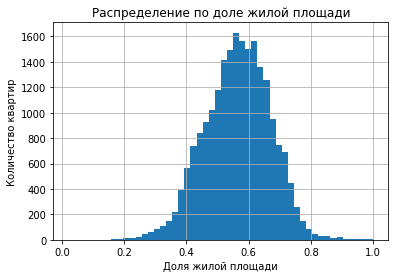

In [50]:
data.living.hist(bins = 50)
plt.title('Распределение по доле жилой площади')
plt.xlabel('Доля жилой площади')
plt.ylabel('Количество квартир');

Распределение доли жилой площади близко к нормальному, хотя есть и аномально низкие значения, но их мало.

In [51]:
data[data.living < 0.3].living.count()

188

Скорее всего, тут тоже нет ошибок: к общей площади обычно относят кухни, балконы и лоджии, санузлы, гардеробные, кладовые и другие помещения. К жилой площади - только спальни и гостиные. Поэтому в некоторых случаях доля жилой площади действительно может быть очень небольшой.

### Квартиры-студии

В датасете есть квартиры, где указано количество комнат 0:

In [52]:
data[data.rooms == 0].studio.mean()

0.6958762886597938

70% из них - студии. Вероятно, остальные тоже являются студиями. Уточним площадь таких квартир:

In [53]:
data[(data.rooms == 0) & (data.studio == False)].total_area.value_counts().sort_index().tail()

34.00     1
34.40     1
35.00     2
42.63     1
371.00    1
Name: total_area, dtype: int64

Если не брать во внимание одну очень нетипичную квартиру с огромной площадью и без комнат, остальные квартиры с 0 комнат можно с большой долей уверенности отнести к студиям: их площадь не превышает 43 м2. Пометим их как студии:

In [54]:
data.loc[((data.rooms == 0) & (data.studio == False) & (data.total_area <= 43)), 'studio'] = True

In [55]:
data[(data.rooms == 0) & (data.total_area <= 43)].studio.mean()

1.0

### Год, месяц и день публикации объявления

Рыночная стоимость жилья может меняться в зависимости от экономической ситуации, сезона и других неочевидных факторов. Чтобы отследить динамику, вынесем **год, месяц и день недели**, когда было опубликовано объявление, в отдельные столбцы:

In [56]:
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data['weekday'] = data['first_day_exposition'].dt.weekday

Итак, мы добавили дополнительные переменные: цену квадратного метра; день недели, месяц и год публикации объявления;
этаж квартиры; соотношение жилой и общей площади, отношение площади кухни к общей, а также провалидировали данные.

# Исследовательский анализ данных<a id = 'research'></a>

Изучим распределение данных в датасете по отдельным параметрам, а затем попробуем понять, какие факторы больше всего влияют на стоимость квартиры.

### Число комнат

Посмотрим распределение по **числу комнат** в нашем датасете:

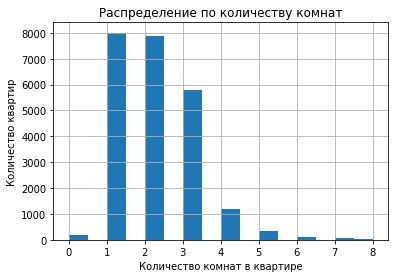

In [57]:
data.hist('rooms', range = (0, 8), bins = 16)
plt.title('Распределение по количеству комнат')
plt.xlabel('Количество комнат в квартире')
plt.ylabel('Количество квартир');

Все выглядит ожидаемо: больше всего однушек и двушек, чуть меньше трешек и сильно меньше квартир с 4 и более комнатами.

### Высота потолков

Теперь посмотрим, какие **потолки** в квартирах:

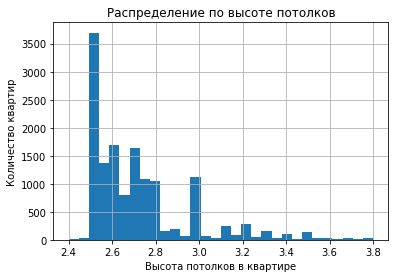

In [58]:
data.hist('ceiling_height', range = (2.4, 3.8), bins = 30)
plt.title('Распределение по высоте потолков')
plt.xlabel('Высота потолков в квартире')
plt.ylabel('Количество квартир');

Тут тоже все ожидаемо: большинство значений - в промежутке между 2.5 и 3 метрами. Но есть и явные аномалии.

In [59]:
data.ceiling_height.describe()

count    14480.000000
mean         2.771285
std          1.262026
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Квартир с высотой потолков 1 м не бывает, равно как и квартир с потолками 100 м. Это явные ошибки. Посмотрим, сколько в датасете таких артефактов. 

Интернет подсказывает: "Сегодня минимальной нормой в России считается высота потолка 2,4 метра. Для элитного жилья показатель может превышать 3 метра.". А если квартира двухэтажная?

In [60]:
data[data.ceiling_height < 2.4].ceiling_height.count()

21

In [61]:
data[data.ceiling_height > 7].ceiling_height.count()

29

Избавимся от этих объектов:

In [62]:
data.drop(data[(data['ceiling_height'] > 7) | (data['ceiling_height'] < 2.4)].index, inplace = True)

### Срок продажи (срок публикации объявления)

Теперь исследуем **срок продажи** квартир, который мы можем косвенно оценивать по сроку публикации объявления:

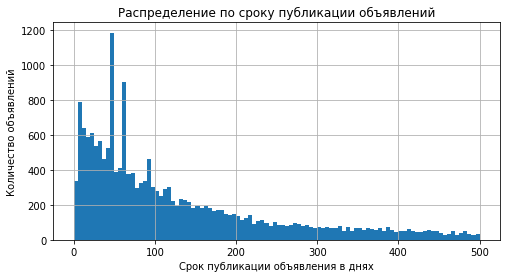

In [63]:
data[data.not_sold == False].hist('days_exposition', range = (0, 500), bins = 100, figsize = (8, 4))
plt.title('Распределение по сроку публикации объявлений')
plt.xlabel('Срок публикации объявления в днях')
plt.ylabel('Количество объявлений');

Подозрительно много очень маленьких значений, а также заметны странные всплески. Что это за дни?

In [64]:
data[data.not_sold == False].days_exposition.value_counts().head(7)

45    875
60    538
7     233
30    208
90    200
4     174
3     157
Name: days_exposition, dtype: int64

Очевидно, эти всплески связаны с длительностью размещения объявлений в Яндекс Недвижимости. Вероятно, объявления автоматически снимаются с публикации, если пользователь не оплачивает следующий период. В таком случае, непонятно, продана ли квартира или же объявление снято с публикации автоматически. На всякий случай пометим объявления, снятые с публикации ровно через 7, 30, 45, 60 или 90 дней, значениями True в столбце not_sold.

In [65]:
data.loc[data.days_exposition.isin([7, 30, 45, 60, 90]), 'not_sold'] = True

In [66]:
data[data.days_exposition.isin([7, 30, 45, 60, 90])]['not_sold'].value_counts()

True    2160
Name: not_sold, dtype: int64

In [67]:
data.days_exposition.describe()

count    23514.000000
mean       185.842477
std        233.617487
min          0.000000
25%         43.000000
50%         94.000000
75%        237.000000
max       1618.000000
Name: days_exposition, dtype: float64

Медиана вдвое ниже среднего арифметического: есть много объявлений с очень долгим периодом публикации. Если не ограничивать диапазон наблюдений на гистограмме, можно увидеть этот длинный хвост значений, сильно превышающих среднее.

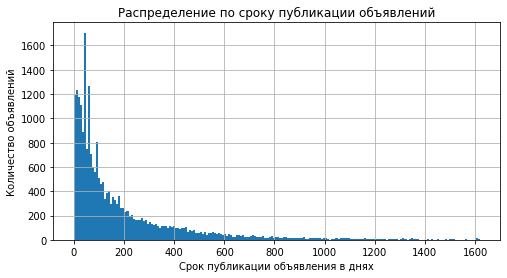

In [68]:
data.hist('days_exposition', bins = 200, figsize = (8, 4))
plt.title('Распределение по сроку публикации объявлений')
plt.xlabel('Срок публикации объявления в днях')
plt.ylabel('Количество объявлений');

Если исключить объекты, которые, вероятно, не были проданы на момент снятия объявления с публикации или на момент выгрузки данных, медианное значение получится даже немного больше:

In [69]:
data[data.not_sold == False].days_exposition.describe()

count    18298.000000
mean       195.787627
std        226.918114
min          1.000000
25%         44.000000
50%        114.000000
75%        259.000000
max       1580.000000
Name: days_exposition, dtype: float64

В целом, можно сказать, что:
- нормальный срок продажи - около 3.5 месяцев;
- только 1 из 4 квартир удается продать менее чем за 1.5 мес;
- если объявление находится на публикации больше 8 месяцев - скорее всего, с ним что-то не так: квартира не востребована или цена завышена.

Посмотрим, зависит ли срок продажи от стоимости квартиры:

In [70]:
data.groupby(data.last_price > 15).days_exposition.median()

last_price
False     91
True     205
Name: days_exposition, dtype: int32

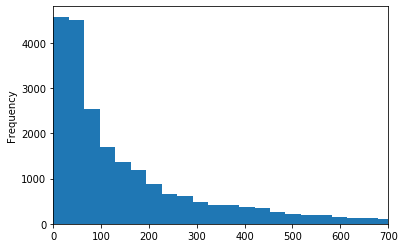

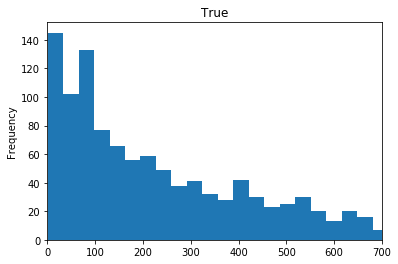

In [71]:
for group_name, group_data in data.groupby(data.last_price > 15):
    group_data.plot(kind = 'hist', y = 'days_exposition', bins = 50, xlim = (0, 700), title = group_name, legend = False)

- Заметно, что среди квартир дороже 15 млн руб. (см.график №2) значительно выше доля тех, которые находятся в продаже много месяцев. 
- Медиана срока публикации для них вдвое выше, чем для квартир дешевле 15 млн руб.

Слишком короткий срок публикации тоже вызывает вопросы. Реально ли продать квартиру за несколько дней?

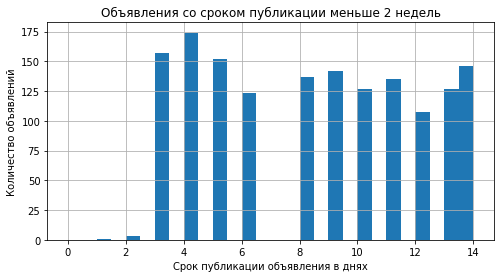

In [72]:
data[data.not_sold == False].hist('days_exposition', range = (0, 14), bins = 28, figsize = (8, 4))
plt.title('Объявления со сроком публикации меньше 2 недель')
plt.xlabel('Срок публикации объявления в днях')
plt.ylabel('Количество объявлений');

Если цены на такие квартиры сильно ниже рыночных, это может вызвать подозрения. Например, бывают такие мошеннические схемы:

"*Собственник сдаёт квартиру мошенникам, которые по поддельным документам продают её ни о чем не подозревающему покупателю. Когда афера раскроется, и собственник подаст в суд, будет возбуждено уголовное дело, и квартиру по итогам расследования ему вернут. А вот обманутый покупатель останется без своих денег.*"

[Источник - Яндекс Недвижимость](https://realty.yandex.ru/spravochnik/arenda-kak-obmanyvayut-kvartirantov-i-sobstvennikov-pri-arende-kvartiry)
    
Или это могут быть объявления, размещенные недобросовестными риелтерами.

[Источник - Яндекс Недвижимость](https://realty.yandex.ru/spravochnik/kak-rieltory-meshayut-vladeltsam-prodat-ili-sdat-kvartiru)

# Взаимосвязи в данных<a id = 'correlation'></a>

Выясним, **какие факторы больше всего влияют на стоимость квартиры**.

### Как площадь квартиры и количество комнат влияют на стоимость

Самый очевидный фактор, влияющий на стоимость квартиры, - ее **площадь**:

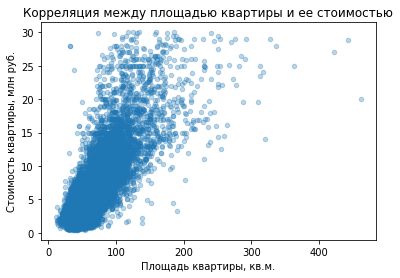

In [73]:
data[data.last_price < 30].plot(x = 'total_area', y = 'last_price', kind = 'scatter', alpha = 0.3).set(xlabel = 'Площадь квартиры, кв.м.', ylabel = 'Стоимость квартиры, млн руб.')
plt.title('Корреляция между площадью квартиры и ее стоимостью');

In [74]:
data['total_area'].corr(data['last_price'])

0.6537561192258766

Зависимость стоимости от метража - прямая, линейная, хорошо выраженная и интуитивно понятная. 

При этом разброс цен на квартиры одного метража может быть очень большим, поскольку на цену влияет множество других факторов.

Посмотрим, как со стоимостью коррелирует **количество комнат** в квартире:

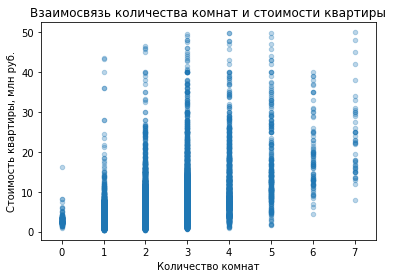

In [75]:
data[data.last_price < 50].plot(x = 'rooms', y = 'last_price', kind = 'scatter', xlim = (-0.5, 7.5), alpha = 0.3).set(xlabel = 'Количество комнат', ylabel = 'Стоимость квартиры, млн руб.')
plt.title('Взаимосвязь количества комнат и стоимости квартиры');

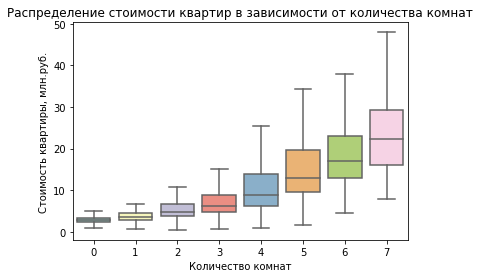

In [76]:
sns.boxplot(x = 'rooms', y = 'last_price', data = data[(data.last_price < 50) & (data.rooms <= 7)], palette = 'Set3', sym = '').set(xlabel = 'Количество комнат', ylabel = 'Стоимость квартиры, млн.руб.')
plt.title('Распределение стоимости квартир в зависимости от количества комнат');

In [77]:
data['rooms'].corr(data['last_price'])

0.3633772824748593

Зависимость стоимости от количества комнат также явная, хотя и более сложная. Бывают как очень просторные квартиры с небольшим количеством комнат, так и маленькие квартиры с большим количеством комнат. Поэтому площадь выглядит более надежным критерием, чем количество комнат.

### Как на стоимость квартиры влияет расстояние от центра города

Что наверняка влияет на стоимость квартир - так это **расстояние от центра**:

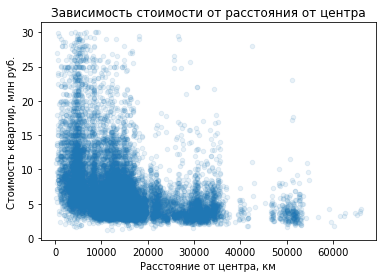

In [78]:
data[data.last_price < 30].plot(x = 'cityCenters_nearest', y = 'last_price', kind = 'scatter', 
        alpha = 0.1).set(xlabel = 'Расстояние от центра, км', ylabel = 'Стоимость квартир, млн руб.')
plt.title('Зависимость стоимости от расстояния от центра');

In [79]:
data['cityCenters_nearest'].corr(data['last_price'])

-0.20641747439369235

Есть обратная корреляция между расстоянием до центра города и стоимостью жилья: чем дальше центр, тем ниже цены. 

Но эта зависимость не линейная: большая квартира в новостройке бизнес-класса на окраине может стоить дороже, чем маленькая квартира в старом доме недалеко от центра.

Большой разброс цен на квартиры, расположенные близко к центру, обусловлен еще и тем, что в датасете представлены данные как по Санкт-Петербургу, так и по небольшим городам Ленинградской области.

### Корреляция между этажом и стоимостью квартиры

Посмотрим, как влияет на цену **этаж** (первый, последний или другой):

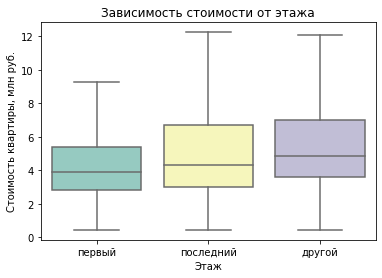

In [80]:
sns.boxplot(x = 'floor_type', y = 'last_price', data = data, 
            order = ['первый', 'последний', 'другой'], 
            sym = "", palette = 'Set3').set(xlabel = 'Этаж', ylabel = 'Стоимость квартиры, млн руб.')
plt.title('Зависимость стоимости от этажа');

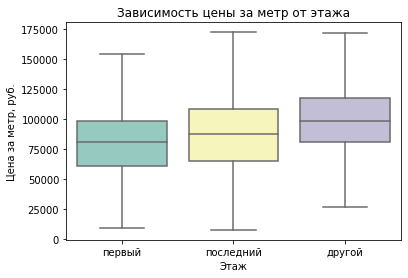

In [81]:
sns.boxplot(x = 'floor_type', y = 'metre_price', data = data, 
            order = ['первый', 'последний', 'другой'], 
            sym = "", palette = 'Set3').set(xlabel = 'Этаж', ylabel = 'Цена за метр, руб.')
plt.title('Зависимость цены за метр от этажа');

Стоимость явно коррелирует с этажом. Это особенно заметно, если смотреть по цене за метр. 

В среднем, цены на квартиры, расположенные на первом этаже, - самые низкие. 

Последние этажи в среднем заметно дешевле, чем остальные (за исключением первых).

### Взаимосвязь между стоимостью и датой публикации объявления

Посмотрим, зависит ли цена от **даты размещения объявления**:

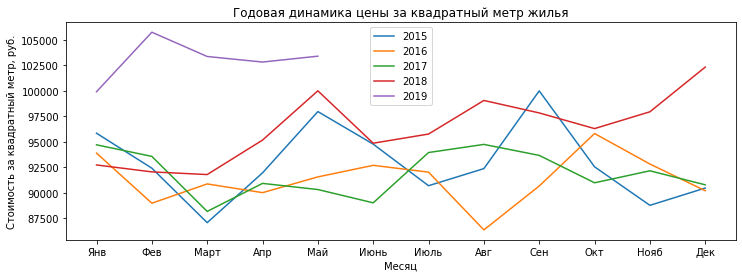

In [82]:
fig, ax = plt.subplots()
data[(data.last_price < 30) & (data.year == 2015)].groupby('month').metre_price.median().plot(figsize = (12, 4), 
                                                                                              label = '2015')
data[(data.last_price < 30) & (data.year == 2016)].groupby('month').metre_price.median().plot(label = '2016')
data[(data.last_price < 30) & (data.year == 2017)].groupby('month').metre_price.median().plot(label = '2017')
data[(data.last_price < 30) & (data.year == 2018)].groupby('month').metre_price.median().plot(label = '2018')
data[(data.last_price < 30) & (data.year == 2019)].groupby('month').metre_price.median().plot(label = '2019')
plt.legend()
plt.title('Годовая динамика цены за квадратный метр жилья')
ax.set_xlabel('Месяц')
ax.set_ylabel('Стоимость за квадратный метр, руб.')
plt.xticks(np.arange(1, 13), ('Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Нояб', 'Дек'));

Заметно, что средняя цена за квадратный метр выросла в 2018 году и особенно в первой половине 2019 года.

Что касается сезонности, можно отметить рост цен весной (апрель-май) и осенью (сентябрь-октябрь).

Может ли цена зависеть от **дня недели**, когда было опубликовано объявление? Это кажется маловероятным, но проверим эту гипотезу.

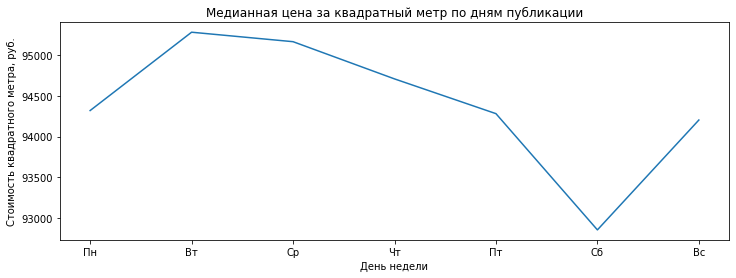

In [83]:
data[data.last_price < 30].groupby('weekday').metre_price.median().plot(figsize = (12, 4)) \
                          .set(xlabel = 'День недели', ylabel = 'Стоимость квадратного метра, руб.')
plt.title('Медианная цена за квадратный метр по дням публикации')
plt.xticks(np.arange(7), ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'));

Интересно: средняя цена за квадратный метр для объявлений, опубликованных во вторник или среду, на 2500 руб выше, чем у объявлений, опубликованных в субботу. Пока непонятно, с чем это связано.

### Стоимость квартир в зависимости от населенного пункта

Посмотрим, как различаются цены в разных **населенных пунктах**. Сначала выберем 10 населенных пунктов с наибольшим количеством объявлений и сохраним их в переменную `top_loc`:

In [84]:
top_loc = data.locality_name.value_counts().head(10)
top_loc

Санкт-Петербург      15628
посёлок Мурино         518
посёлок Шушары         439
Всеволожск             397
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                306
деревня Кудрово        299
Выборг                 235
Name: locality_name, dtype: int64

Теперь посмотрим, как различается средняя (медианная) стоимость за квадратный метр в этих населенных пунктах:

In [85]:
data[data.locality_name.isin(top_loc.index)].pivot_table(index = 'locality_name', values = 'metre_price', aggfunc = 'median').sort_values('metre_price', ascending = False)

,metre_price
locality_name,
Санкт-Петербург,104801.0
Пушкин,99999.0
деревня Кудрово,91860.0
посёлок Парголово,91642.0
посёлок Мурино,85878.0
посёлок Шушары,76829.0
Колпино,74723.5
Гатчина,67860.0
Всеволожск,65789.0


Самое дорогое жилье - в Петербурге, что ожидаемо. Самое доступное - в Выборге, где цена за метр чуть ли не вдвое ниже.

Теперь посмотрим, **как меняется стоимость квартир в Петербурге в зависимости от расстояния до центра**.

Для удобства переведем расстояние до центра в километры и округлим до целых значений:

In [86]:
data.loc[~data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = data.loc[~data['cityCenters_nearest'].isna(), 'cityCenters_nearest'].apply(lambda x: round(x/1000))

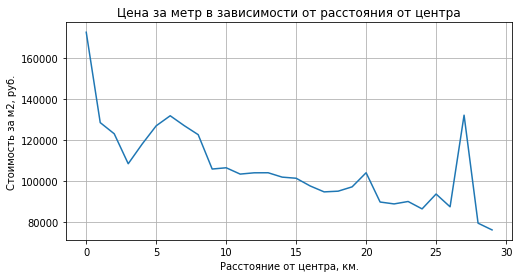

In [87]:
data[data['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_nearest') \
.metre_price.agg('median') \
.plot(figsize = (8, 4), grid = True).set(xlabel = 'Расстояние от центра, км.', 
                                         ylabel = 'Стоимость за м2, руб.')
plt.title('Цена за метр в зависимости от расстояния от центра');

Заметно два пороговых значения, где цена заметно снижается: 8 км от центра и 20 км от центра.

- Основные факторы, которые влияют на стоимость квартиры, - это площадь и этаж, населенный пункт и расстояние от центра.
- Цены на квартиры меняются от года к году, также заметна сезонность (цены немного выше весной и осенью).

## Сравнение квартир в центре Санкт-Петербурга и в целом по городу <a id = 'spbvscenter'></a>

Проанализируем отдельно квартиры в центре Петербурга (`spb_center`), сравним параметры этих квартир с показателями по Петербургу в целом (`spb`):

In [88]:
spb_center = data[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'] <= 8)]

In [89]:
spb = data[data['locality_name'] == 'Санкт-Петербург']

Сначала сравним **стоимость квартир**:

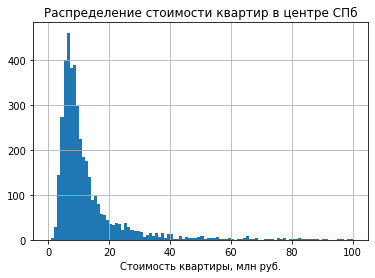

In [90]:
spb_center.last_price.hist(range = (0, 100), bins = 100).set(xlabel = 'Стоимость квартиры, млн руб.')
plt.title('Распределение стоимости квартир в центре СПб');

In [91]:
spb_center.last_price.describe()

count    4106.000000
mean       14.182457
std        23.620501
min         1.600000
25%         6.450000
50%         8.950000
75%        13.900000
max       763.000000
Name: last_price, dtype: float64

In [92]:
spb.last_price.describe()

count    15628.000000
mean         8.068158
std         13.045027
min          1.190000
25%          4.200000
50%          5.500000
75%          8.158275
max        763.000000
Name: last_price, dtype: float64

Распределение цен на квартиры в центре СПб похоже на общее распределение по нашему датасету: близко к нормальному, но с длинным хвостом очень дорогих квартир. 

Самые дорогие квартиры в нашем датасете расположены именно здесь. Поэтому медиана цены за квартиру в центре - почти 9 млн, а в среднем по Петербургу - 5.5 млн руб. Разница в среднем арифметическом еще заметнее: 14 млн и 8 млн, соответственно.

Теперь сравним **площадь** квартир в центре со средними показателями по городу:

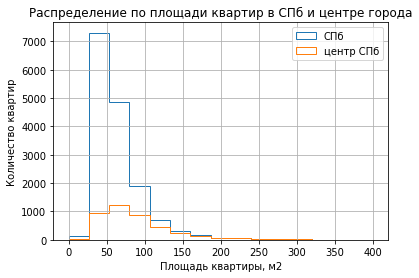

In [93]:
spb.total_area.hist(histtype = 'step', range = (0, 400), bins = 15, label = 'СПб') \
                .set(xlabel = 'Площадь квартиры, м2', ylabel = 'Количество квартир')
spb_center.total_area.hist(histtype = 'step', range = (0, 400), bins = 15, label = 'центр СПб')
plt.legend()
plt.title('Распределение по площади квартир в СПб и центре города');

Заметно, что в центре доля больших квартир заметно выше, чем в целом по городу.

In [94]:
len(spb_center.query('total_area >= 75')) / len(spb_center)

0.5177788602045786

In [95]:
len(spb.query('total_area >= 75')) / len(spb)

0.2485282825697466

Больше половины квартир в центре имеют площадь больше 75 м2, в то время как в целом по Петербургу таких меньше 25%.

С **числом комнат** и **высотой потолков** ситуация аналогичная:

In [96]:
len(spb.query('rooms >= 4')) / len(spb) * 100

9.220629639109292

In [97]:
len(spb_center.query('rooms >= 4')) / len(spb_center) * 100

22.35752557233317

В центре доля квартир с 4 комнатами и более - 22%. В среднем по СПб - всего 9%.

In [98]:
len(spb.query('ceiling_height >= 3')) / len(spb) * 100

14.685180445354492

In [99]:
len(spb_center.query('ceiling_height >= 3')) / len(spb_center) * 100

41.57330735509011

В центре почти 42% квартир имеют высоту потолков более 3 м. В целом по Петербургу таких только 15%.

In [111]:
#напишем функцию для построения boxplot
def create_boxplot(Data, X, Y, Xlabel, Ylabel, Title):
    sns.boxplot(x = X, y = Y, data = Data, sym = '', palette = 'Set3').set(xlabel = Xlabel, ylabel = Ylabel)
    plt.title(Title)

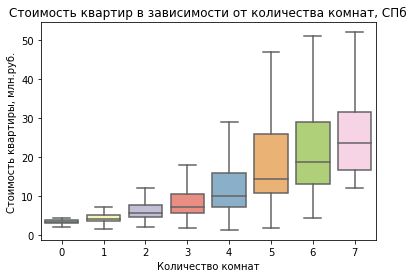

In [112]:
create_boxplot(spb[(spb.rooms <= 7) & (spb.last_price < 100)], 'rooms', 'last_price', 'Количество комнат', 'Стоимость квартиры, млн.руб.', 
               'Стоимость квартир в зависимости от количества комнат, СПб')

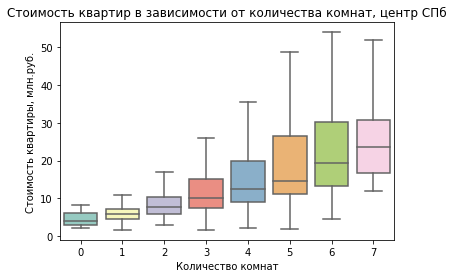

In [113]:
create_boxplot(spb_center[(spb_center.rooms <= 7) & (spb_center.last_price < 100)], 'rooms', 'last_price', 'Количество комнат', 'Стоимость квартиры, млн.руб.', 
               'Стоимость квартир в зависимости от количества комнат, центр СПб')

Заметно, что разброс цен на квартиры в центре сильно выше, чем в среднем по Петербургу. Именно потому, что здесь сосредоточены дорогие и очень дорогие квартиры.

Отличается ли корреляция стоимости с **этажом** от общей картины?

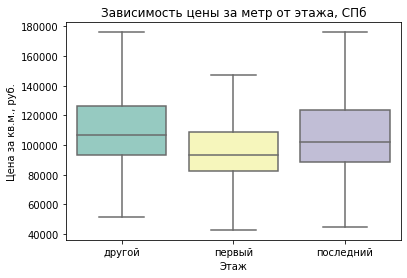

In [114]:
create_boxplot(spb, 'floor_type', 'metre_price', 'Этаж', 'Цена за кв.м., руб.', 
               'Зависимость цены за метр от этажа, СПб')

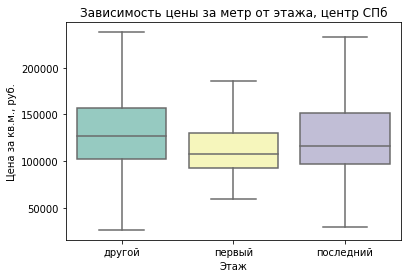

In [115]:
create_boxplot(spb_center, 'floor_type', 'metre_price', 'Этаж', 'Цена за кв.м., руб.', 
               'Зависимость цены за метр от этажа, центр СПб')

Графики по Петербургу в целом и по центру города практически идентичны, хотя цены за метр заметно различаются.

Теперь посмотрим на **расстояние от центра**:

In [105]:
spb['last_price'].corr(spb['cityCenters_nearest'])

-0.2591938128820245

In [106]:
spb_center['last_price'].corr(spb_center['cityCenters_nearest'])

-0.07594798844962751

В центре корреляция цены и расстояния от центра менее выражена, потому что мы уже сильно ограничили расстояние от центра: радиусом 8 км. В пределах этого радиуса цена, очевидно, не так сильно коррелирует с расстоянием, как если сравнивать центр и окраины города.

Проверим на новых срезах данных, есть ли какая-то зависимость между стоимостью и **датой публикации объявления**:

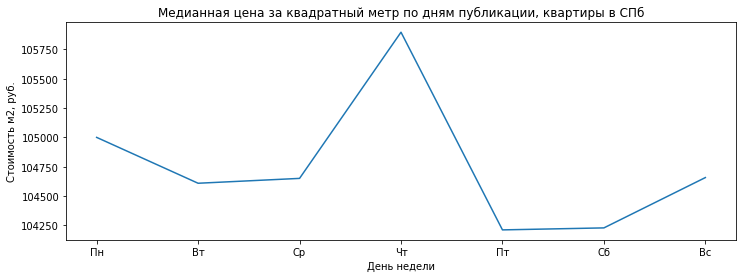

In [107]:
spb.groupby('weekday').metre_price.median().plot(figsize = (12, 4)).set(xlabel = 'День недели',
                                                                       ylabel = 'Стоимость м2, руб.')
plt.title('Медианная цена за квадратный метр по дням публикации, квартиры в СПб')
plt.xticks(np.arange(7), ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'));

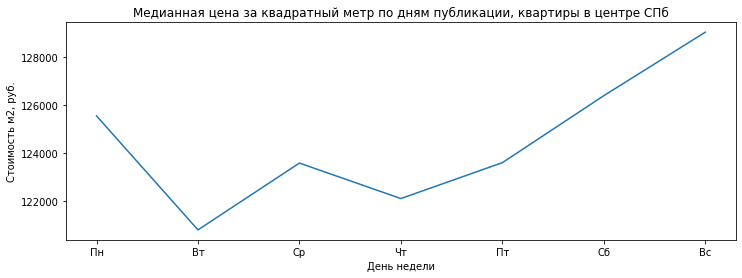

In [108]:
spb_center.groupby('weekday').metre_price.median().plot(figsize = (12, 4)).set(xlabel = 'День недели',
                                                                        ylabel = 'Стоимость м2, руб.')
plt.title('Медианная цена за квадратный метр по дням публикации, квартиры в центре СПб')
plt.xticks(np.arange(7), ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'));

На графиках со стоимостью за метр по дням публикации картина меняется от выборки к выборке. Никаких общих тенденций выявить не удается. Вероятно, никакой зависимости здесь нет эти и различия носят случайный характер.

Посмотрим на динамику цен на недвижимость в центре СПб и в Петербурге в целом по годам и месяцам:

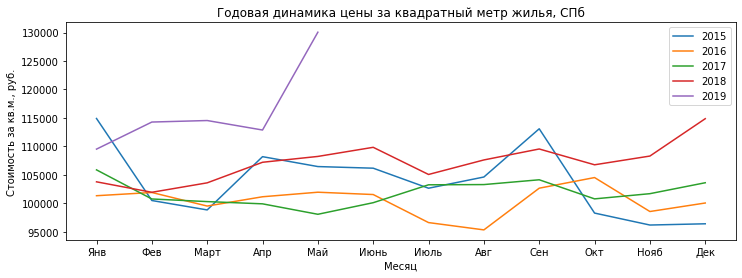

In [109]:
fig, ax = plt.subplots()
spb[spb.year == 2015].groupby('month').metre_price.median().plot(figsize = (12, 4), label = '2015')
spb[spb.year == 2016].groupby('month').metre_price.median().plot(label = '2016')
spb[spb.year == 2017].groupby('month').metre_price.median().plot(label = '2017')
spb[spb.year == 2018].groupby('month').metre_price.median().plot(label = '2018')
spb[spb.year == 2019].groupby('month').metre_price.median().plot(label = '2019')
plt.legend()
plt.title('Годовая динамика цены за квадратный метр жилья, СПб')
ax.set_xlabel('Месяц')
ax.set_ylabel('Стоимость за кв.м., руб.')
plt.xticks(np.arange(1, 13), ('Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Нояб', 'Дек'));

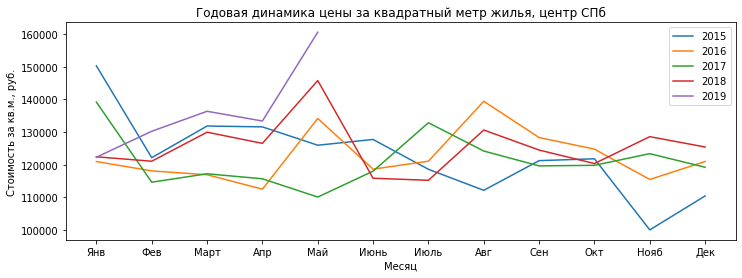

In [110]:
fig, ax = plt.subplots()
spb_center[spb_center.year == 2015].groupby('month').metre_price.median().plot(figsize = (12, 4), label = '2015')
spb_center[spb_center.year == 2016].groupby('month').metre_price.median().plot(label = '2016')
spb_center[spb_center.year == 2017].groupby('month').metre_price.median().plot(label = '2017')
spb_center[spb_center.year == 2018].groupby('month').metre_price.median().plot(label = '2018')
spb_center[spb_center.year == 2019].groupby('month').metre_price.median().plot(label = '2019')
plt.legend()
plt.title('Годовая динамика цены за квадратный метр жилья, центр СПб')
ax.set_xlabel('Месяц')
ax.set_ylabel('Стоимость за кв.м., руб.')
plt.xticks(np.arange(1, 13), ('Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Нояб', 'Дек'));

Графики выглядят похожими. Динамика цен на квартиры в центре СПб отличается более явно выраженной сезонностью. Рост цен в 2019 году по сравнению с 2018 не такой заметный. Но эти различия могут объясняться меньшим размером выборки.

- В центре Санкт-Петербурга сосредоточены самые дорогие и просторные квартиры, с большим количеством комнат и высокими потолками. Поэтому средние значения основных параметров, которые мы рассматриваем в ходе анализа, здесь ощутимо выше, чем в среднем по Петербургу.

- При этом общие тенденции те же, что и по всему датасету: на стоимость квартир влияют одни и те же основные факторы, будь то дорогая квартира в центре Санкт-Петербурга или недорогое жилье в Выборге.

# Выводы <a id = 'summary'></a>

- В датасете много пропусков. Больше 23% строк содержат пропуски в автоматически сгенерированных столбцах. Составили баг-репорт, чтобы избавиться от пропусков в этих столбцах при следующей выгрузке данных.  


- Распределение цен на квартиры в датасете близко к нормальному, с длинным хвостом очень дорогих квартир. Самые дорогие квартиры сосредоточены в центре Санкт-Петербурга, а самое доступное жилье по цене за квадратный метр - в Выборге.


- Медиана стоимости квартиры - 4.65 млн руб, а медианная цена за квадратный метр - 95 000 руб.


- Медиана площади квартиры в датасете - 52 кв.м. Преобладают однушки, двушки и трешки. Распределение метража также близко к нормальному, с длинным хвостом значений, сильно превышающих средние значения.


- Большинство квартир имеет высоту потолков от 2.5 м до 2.8 м.


- Нормальный срок продажи - около 3.5 месяцев. Только 1 из 4 квартир удается продать менее чем за 1.5 мес. Если объявление находится на публикации больше 8 месяцев - скорее всего, с ним что-то не так: квартира не востребована или цена завышена.


- В целом, цены на квартиры, расположенные на первом этаже, - самые низкие. Последние этажи в среднем заметно дешевле, чем остальные (за исключением первых).


- Средняя цена за квадратный метр выросла в 2018 году и особенно в первой половине 2019 года. Что касается сезонности, можно отметить рост цен весной (апрель-май) и осенью (сентябрь-октябрь).


- Основные факторы, которые влияют на стоимость квартиры, - это метраж и этаж, населенный пункт и расстояние от центра города.


- На стоимость квартир влияют одни и те же основные факторы, будь то дорогая квартира в центре Санкт-Петербурга или недорогое жилье в Выборге.


- За счет того, что в центре Санкт-Петербурга (в радиусе 8 км) высокая концентрация премиального жилья, средние цены и другие параметры жилья здесь заметно выше, чем в среднем по городу.


- Медиана цены за квартиру в центре - почти 9 млн руб, а в среднем по Петербургу - 5.5 млн руб.


- Больше половины квартир в центре имеют площадь больше 75 м2, в то время как в целом по Петербургу таких меньше 25%.


- В центре почти 42% квартир имеют высоту потолков более 3 м. В целом по Петербургу таких только 15%.


- При разработке модели для определения рыночной стоимости жилья рекомендуется использовать стоимость за квадратный метр, как более универсальную метрику, по сравнению с ценой квартиры.